In [1]:
import sys
import numpy as np


sys.path.append("..")

from scripts.load_results import load_results

from strategic_ttc.verifiers.boxed_number import parse_pred_from_explanation
from strategic_ttc.verifiers.gpqa import parse_pred_from_explanation_gpqa


import strategic_ttc.core.accuracy_analysis as aa
import strategic_ttc.core.game_dynamics as gm
from strategic_ttc.core.auction import compare_market_to_auction
import scripts.utils as ut

/NL/strategic-compute/work/svenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load results

In [2]:
BENCHMARK = "GPQA"
ALPHA = 0.02 # 0.008 for GSM8K and 0.05 for AIME

In [3]:
results = load_results(f"../final_runs/{BENCHMARK}")

if BENCHMARK in {"GSM8K", "AIME"}:
    pred_fn = parse_pred_from_explanation
else:
    pred_fn = parse_pred_from_explanation_gpqa

model_color = ut.assign_colors(results.keys())
reasoning_models, unreasoning_models = ut.categorize_models(results.keys())

Bad JSON at line 610: Expecting value: line 1 column 1 (char 0)
Offending line repr: 'rsed=\'C\'; truth=\'B\'", "parsed=\'D\'; truth=\'B\'", "parsed=\'B\'; truth=\'B\'", "parsed=\'C\'; truth=\'B\'", "parsed=\'D\'; truth=\'B\'", "no Answer: <LETTER> found; truth=\'B\'", "parsed=\'C\'; truth=\'B\'", "parsed=\'D\'; '


# Accuracy analysis

## Non-reasoning models

In [4]:
unreasoning_models_data = aa.unreasoning_models_data(
    unreasoning_models, results, pred_fn
)
models_data_llama, models_data_qwen = ut.categorize_families(unreasoning_models_data)

Processing Llama-3-8B...
Processing Llama-3.1-8B...
Processing Llama-3.2-1B...
Processing Llama-3.2-3B...
Processing Qwen2-0.5B...
Processing Qwen2-1.5B...
Processing Qwen2-7B...
Processing Qwen2.5-3B...
Processing Qwen2.5-7B...


Saved files to ../figures/GPQA/accuracies/unreasoning/llama/_*.pdf


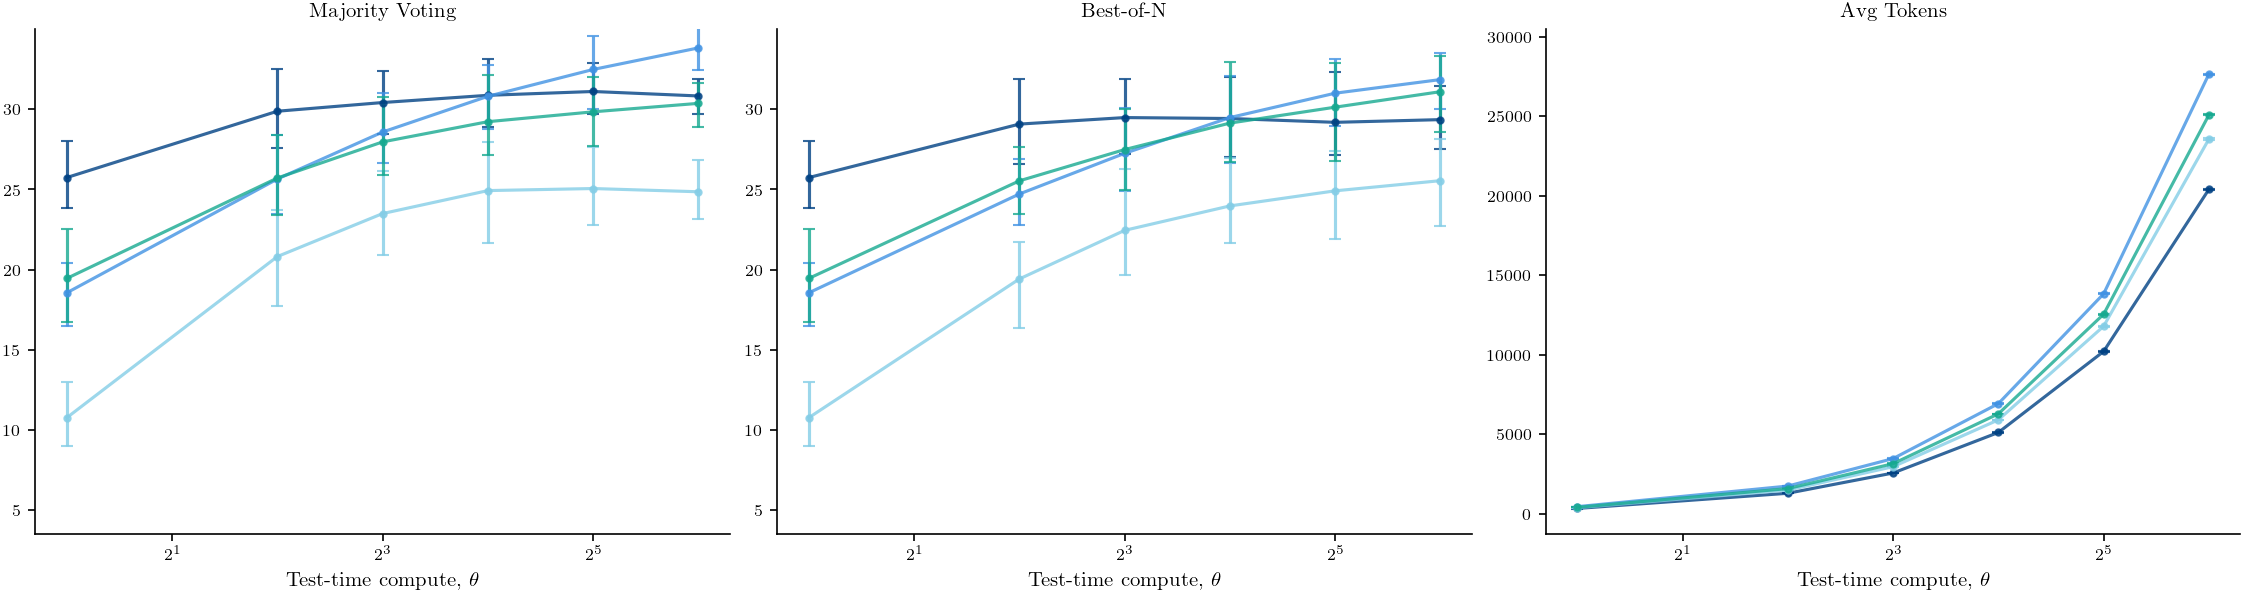

Saved files to ../figures/GPQA/accuracies/unreasoning/qwen/_*.pdf


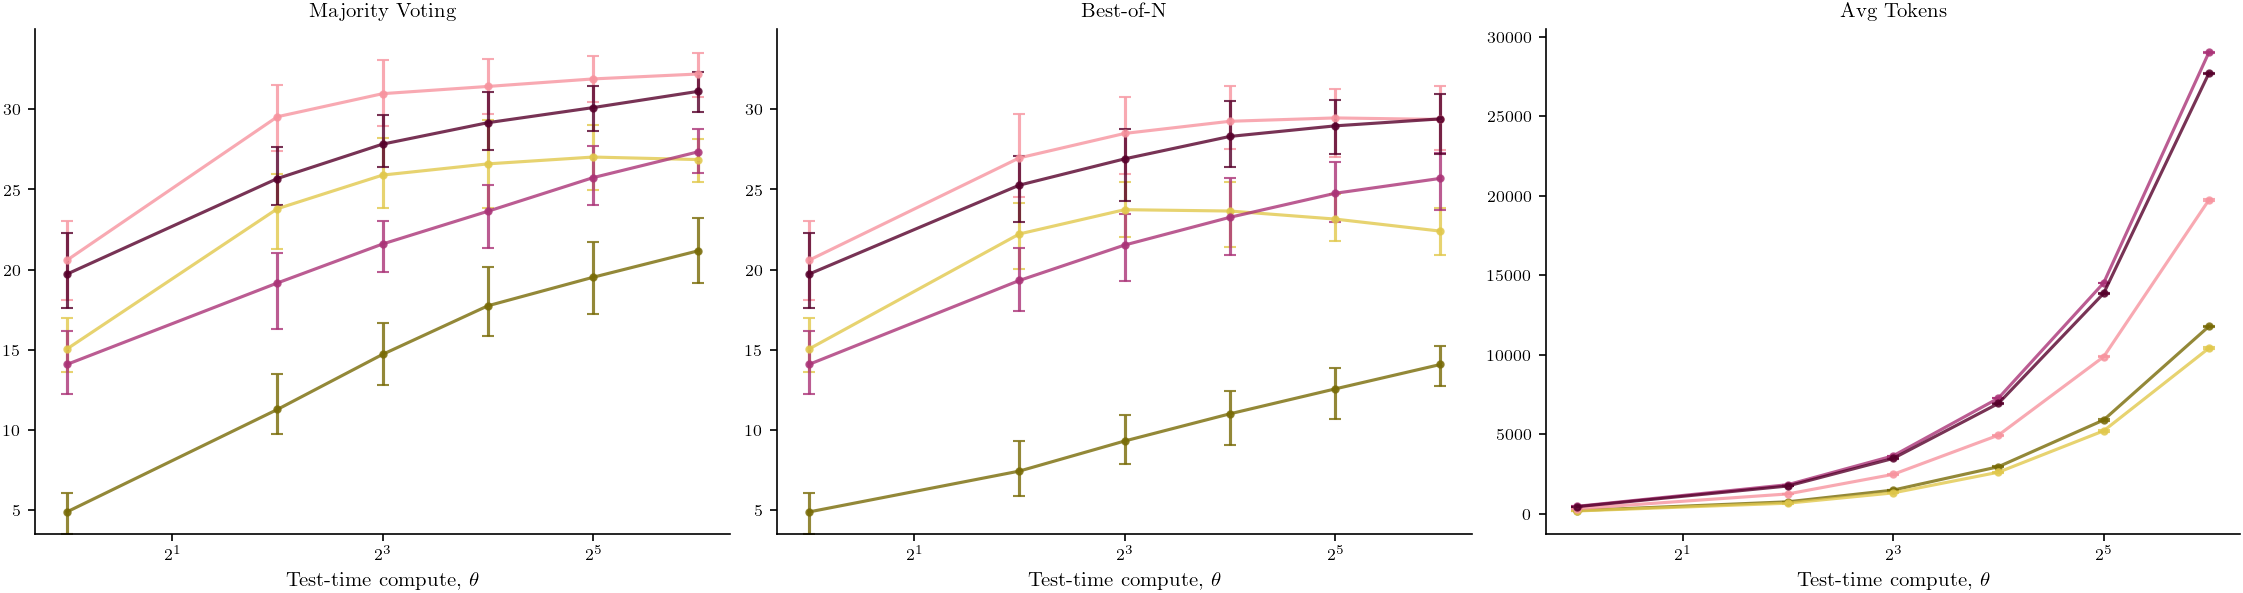

In [5]:
ylim_accuracy, ylim_tokens = ut.compute_shared_limits(
    models_data_llama,
    models_data_qwen,
)

ut.save_separated_plots_overlaid(
    models_data_llama,
    f"../figures/{BENCHMARK}/accuracies/unreasoning/llama/",
    colors=model_color,
    ylim_accuracy=ylim_accuracy,
    ylim_tokens=ylim_tokens,
    samples_disp=False,
)

ut.save_separated_plots_overlaid(
    models_data_qwen,
    f"../figures/{BENCHMARK}/accuracies/unreasoning/qwen/",
    colors=model_color,
    ylim_accuracy=ylim_accuracy,
    ylim_tokens=ylim_tokens,
    samples_disp=True,
)

## Reasoning models

Processing reason-R1-D-Llama-8B...
Processing reason-R1-D-Qwen-1.5B...
Processing reason-R1-D-Qwen-7B...


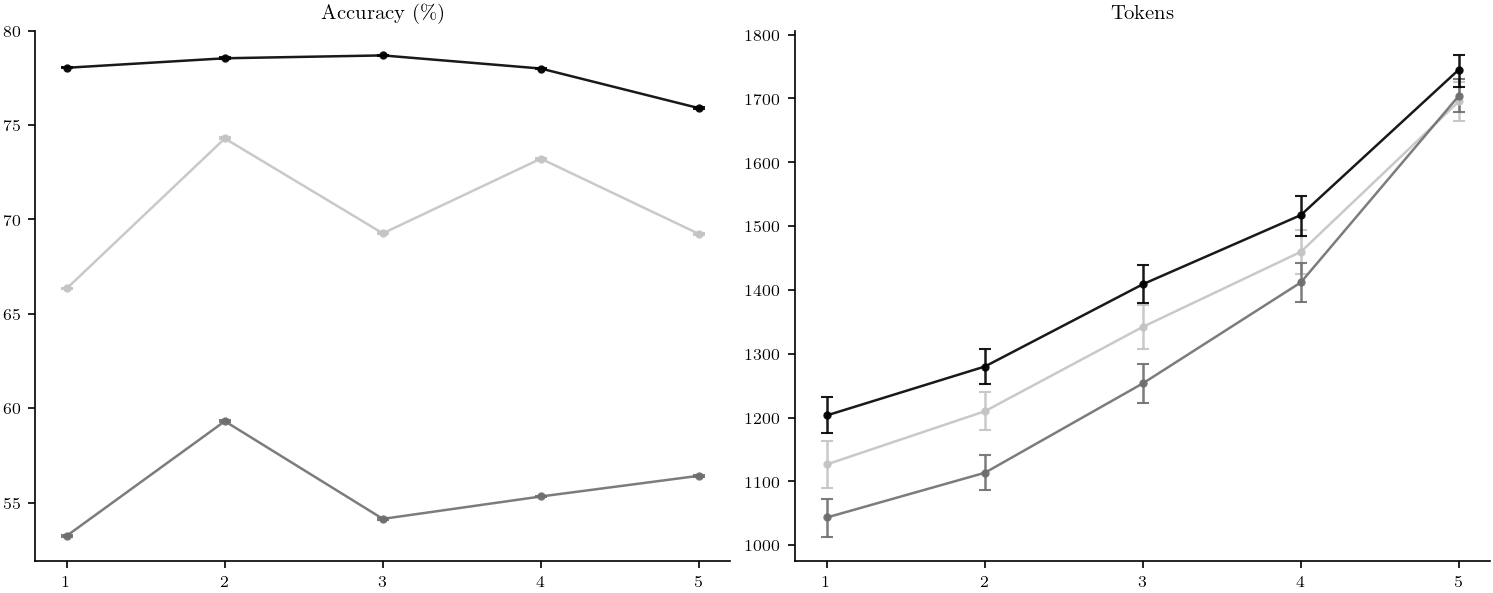

In [6]:
reasoning_plot_data = aa.reasoning_models_data(reasoning_models, results, B=2000)

ut.save_reasoning_plots_separated(
    reasoning_plot_data,
    f"../figures/{BENCHMARK}/accuracies/reasoning/",
    colors=model_color,
)

# Dynamics analysis

In [7]:
config = gm.MarketConfig(
    alpha=ALPHA,
    default_margin=0.25,
    value_curve="linear",
)
thetas_unreasoning = np.array([1, 4, 8, 16, 32, 64])

## Non-reasoning models / Majority

In [8]:
ttc_type = "majority"
unreasoning_providers = gm.init_providers(unreasoning_models_data, ttc_type=ttc_type)

Initializing provider for Llama-3-8B...
Initializing provider for Llama-3.1-8B...
Initializing provider for Llama-3.2-1B...
Initializing provider for Llama-3.2-3B...
Initializing provider for Qwen2-0.5B...
Initializing provider for Qwen2-1.5B...
Initializing provider for Qwen2-7B...
Initializing provider for Qwen2.5-3B...
Initializing provider for Qwen2.5-7B...


### Value offered by providers vs compute level

Saved: ../figures/GPQA/dynamics/unreasoning/majority/values/v_curves.pdf


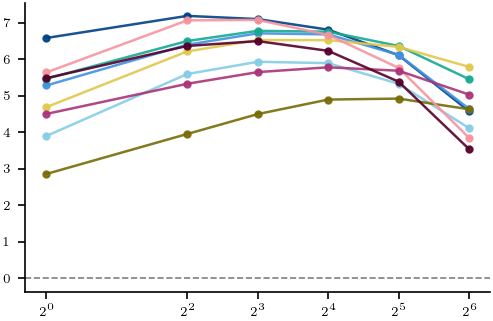

In [9]:
Vs = gm.compute_V_curves(thetas_unreasoning, unreasoning_providers, config)

ut.plot_v_curves(
    Vs,
    thetas_unreasoning,
    config,
    f"../figures/{BENCHMARK}/dynamics/unreasoning/{ttc_type}/values/",
    colors=model_color,
)

### Analyze market dynamics

In [10]:
betas_to_test = [200, 1000, 100000]
profit_margin = 0.25

market_dynamics_unreasoning = gm.compute_market_dynamics(
    betas_to_test, profit_margin, unreasoning_providers, config
)

100%|██████████| 3/3 [00:21<00:00,  7.14s/it]


In [11]:
compare_market_to_auction(
    betas=betas_to_test,
    market_dynamics=market_dynamics_unreasoning,
    value_curves=Vs,
    providers=unreasoning_providers,
    base_config=config,
    profit_margin=profit_margin
)

BETA: 200
	Average Weighted Value: 0.00453
	Average Value: 0.00463
	Optimal SW: 0.00636, Equilibrium SW: 0.00499
	Average Weighted Price: 0.00233
	Average Price: 0.00254
	Average Weighted Utility: 0.00047
	Average Utility: 0.00051

BETA: 1000
	Average Weighted Value: 0.00613
	Average Value: 0.00581
	Optimal SW: 0.00689, Equilibrium SW: 0.00637
	Average Weighted Price: 0.00121
	Average Price: 0.00128
	Average Weighted Utility: 0.00024
	Average Utility: 0.00026

BETA: 100000
	Average Weighted Value: 0.00710
	Average Value: 0.00637
	Optimal SW: 0.00723, Equilibrium SW: 0.00718
	Average Weighted Price: 0.00038
	Average Price: 0.00041
	Average Weighted Utility: 0.00008
	Average Utility: 0.00008

AUCTION RESULTS
Winner: Llama-3-8B (W=0.00723)
Runner-up: Qwen2-7B (W=0.00718)

	Realized User Value: 0.00718
	Realized Price: 0.00020
	Realized Utility: 0.00005
	Total SW: 0.00723
----------------------------------------------------------------------------------------------------


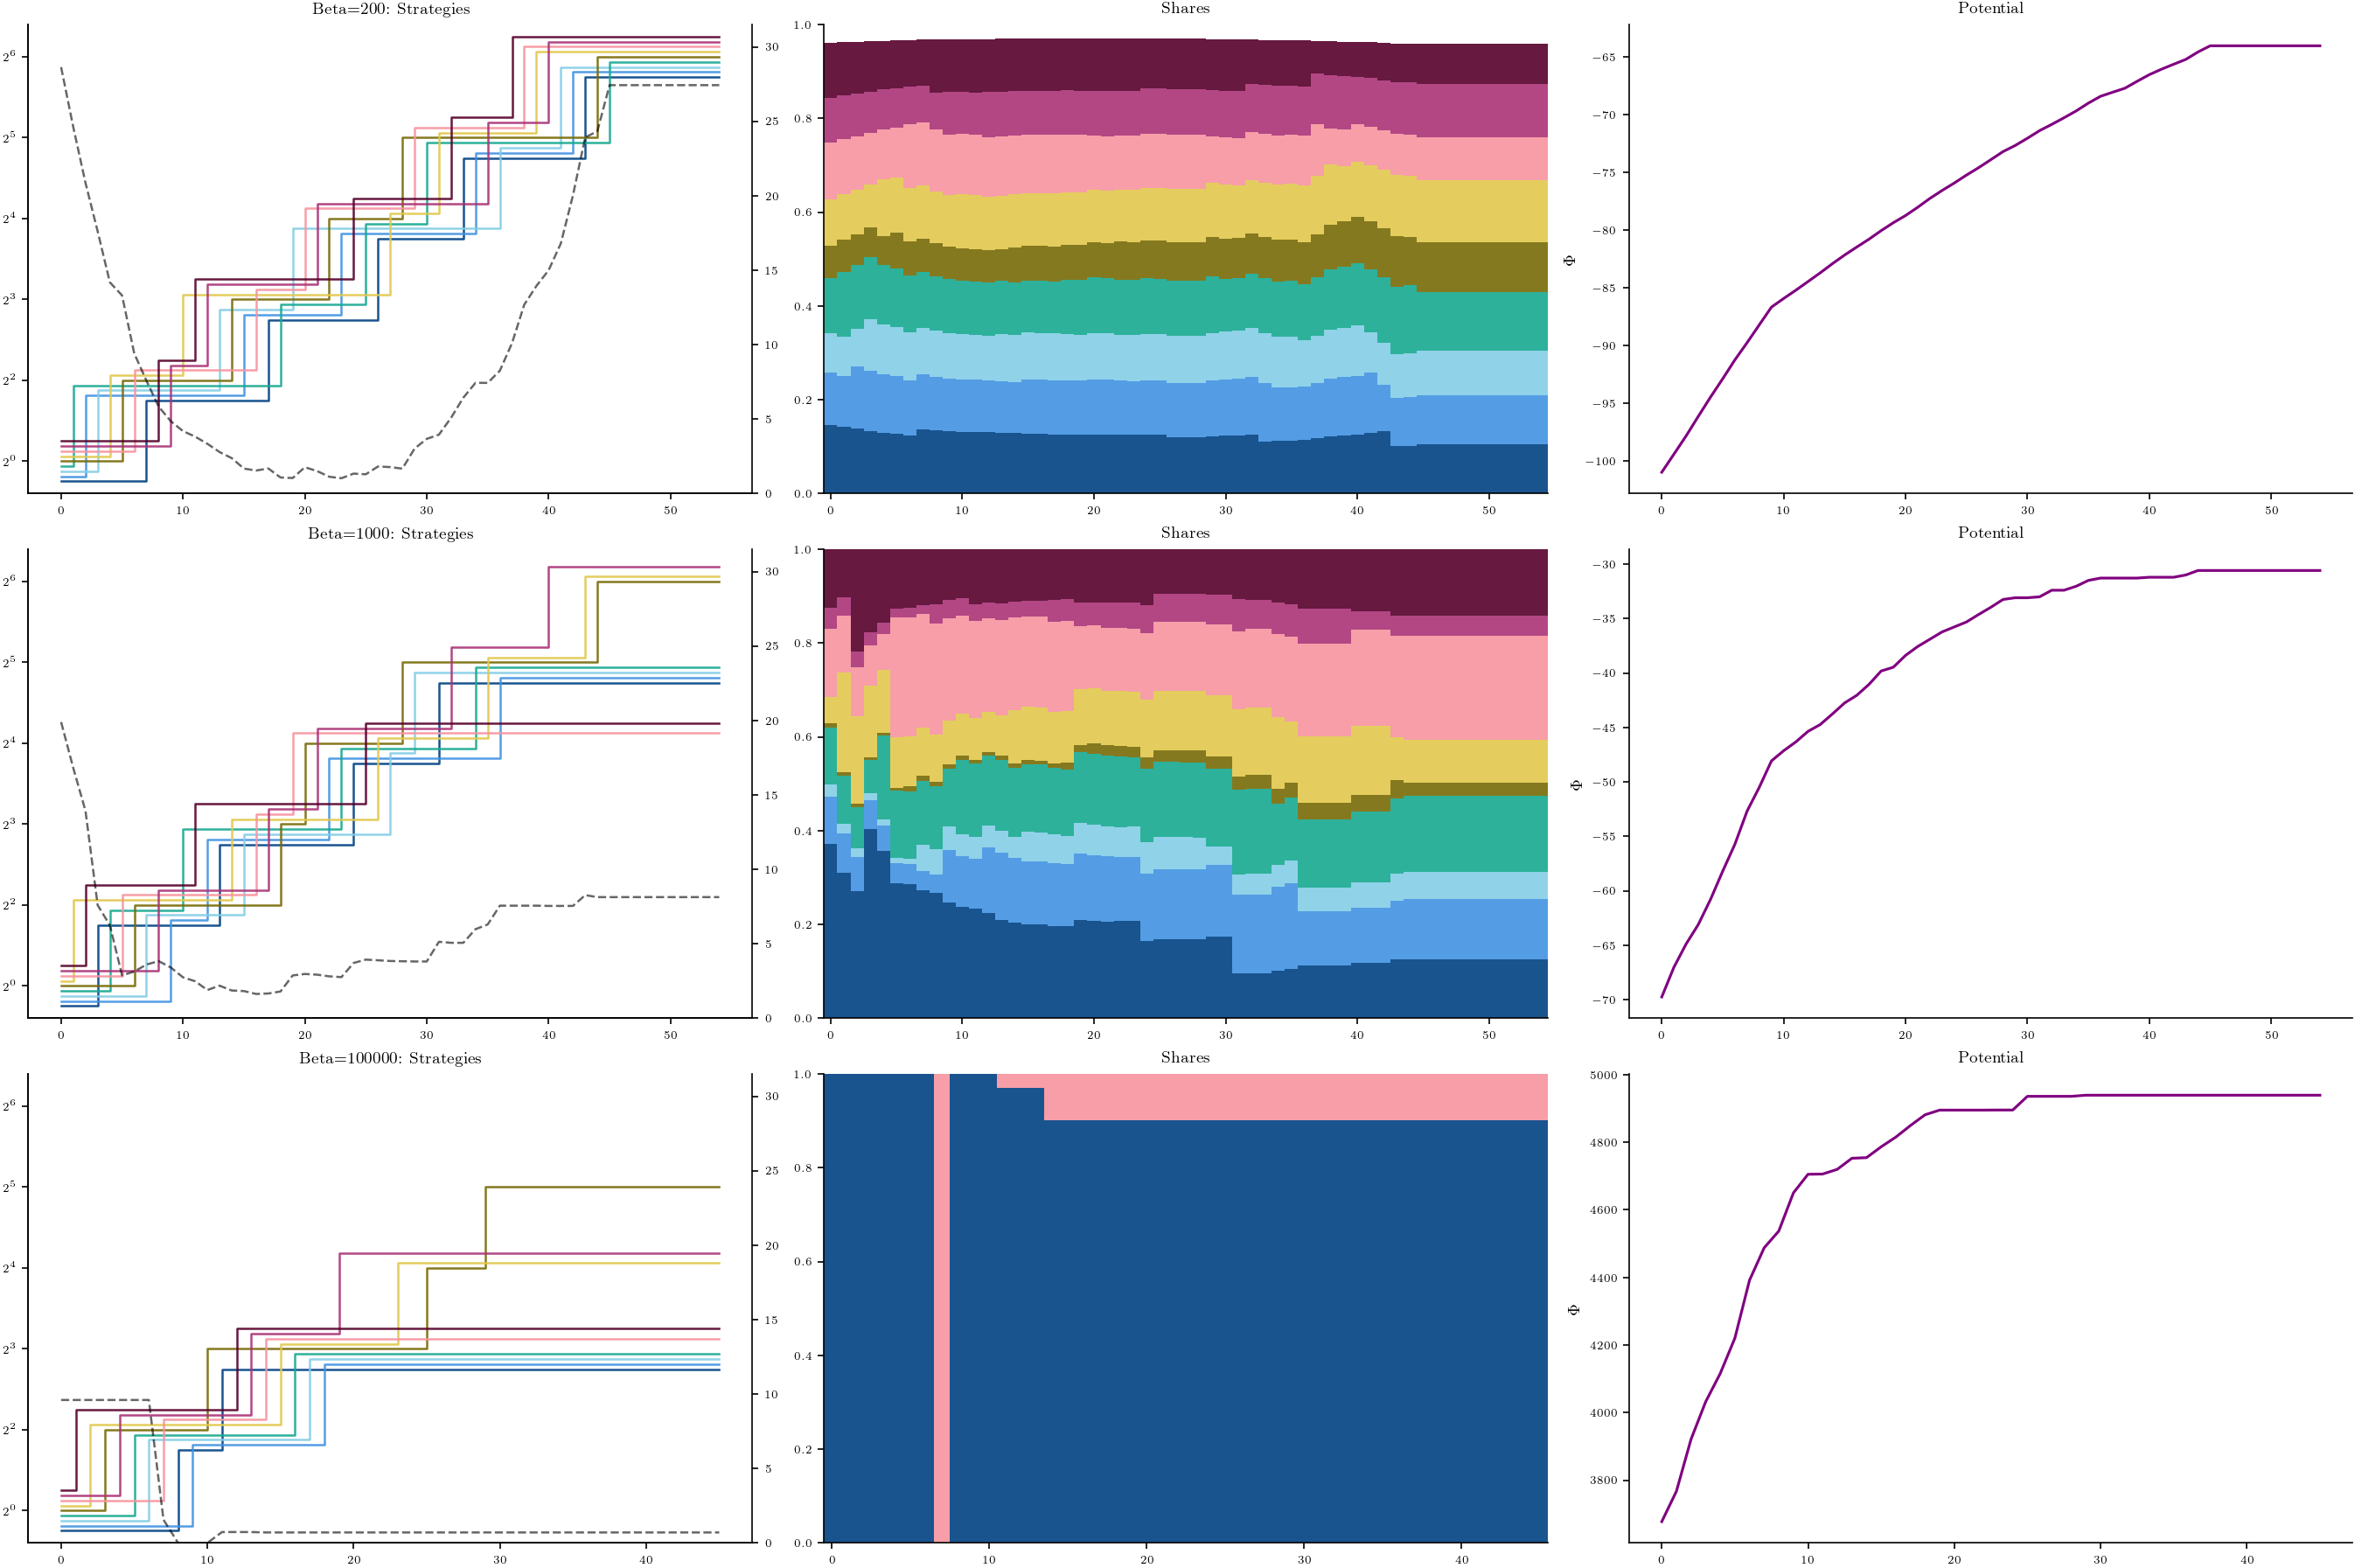

In [12]:
ut.bet_pot_analysis(
    unreasoning_providers,
    thetas_unreasoning,
    betas_to_test,
    market_dynamics_unreasoning,
    base_filename=f"../figures/{BENCHMARK}/dynamics/unreasoning/{ttc_type}/convergence/",
    colors=model_color,
    reasoning=False,
)

ut.plot_market_shares(
    unreasoning_providers,
    betas_to_test,
    market_dynamics_unreasoning,
    base_filename=f"../figures/{BENCHMARK}/dynamics/unreasoning/{ttc_type}/convergence/",
    colors=model_color,
)

ut.plot_combined_dynamics(
    unreasoning_providers,
    thetas_unreasoning,
    betas_to_test,
    market_dynamics_unreasoning,
    base_filename=f"../figures/{BENCHMARK}/dynamics/unreasoning/{ttc_type}/convergence/",
    colors=model_color,
    reasoning=False,
)

In [ ]:
final_poas, final_potentials = gm.sweep_beta_vs_poa(unreasoning_providers, config, np.logspace(0, 6, num=100))

ut.plot_beta_sweep(
    np.logspace(0, 6, num=100),
    final_poas,
    f"../figures/{BENCHMARK}/dynamics/unreasoning/{ttc_type}/convergence/",
)

 23%|██▎       | 23/100 [03:51<13:07, 10.23s/it]

## Non-reasoning models / Best-of-N

In [ ]:
ttc_type = "best-of-n"
unreasoning_providers = gm.init_providers(unreasoning_models_data, ttc_type=ttc_type)

Initializing provider for Llama-3-8B...
Initializing provider for Llama-3.1-8B...
Initializing provider for Llama-3.2-1B...
Initializing provider for Llama-3.2-3B...
Initializing provider for Qwen2-0.5B...
Initializing provider for Qwen2-1.5B...
Initializing provider for Qwen2-7B...
Initializing provider for Qwen2.5-3B...
Initializing provider for Qwen2.5-7B...


### Value offered by providers vs compute level

Saved: ../figures/GSM8K/dynamics/unreasoning/best-of-n/values/v_curves.pdf


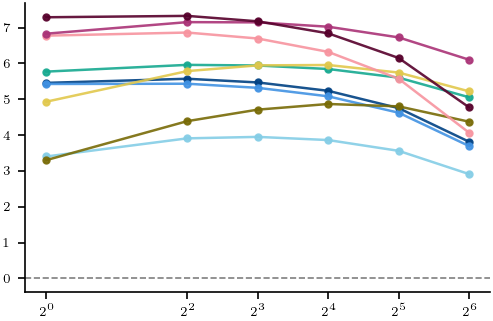

In [ ]:
Vs = gm.compute_V_curves(thetas_unreasoning, unreasoning_providers, config)

ut.plot_v_curves(
    Vs,
    thetas_unreasoning,
    config,
    f"../figures/{BENCHMARK}/dynamics/unreasoning/{ttc_type}/values/",
    colors=model_color,
)

### Analyze market dynamics

In [ ]:
betas_to_test = [200, 1000, 100000]
profit_margin = 0.25

market_dynamics_unreasoning = gm.compute_market_dynamics(
    betas_to_test, profit_margin, unreasoning_providers, config
)

100%|██████████| 3/3 [00:14<00:00,  4.99s/it]


In [ ]:
compare_market_to_auction(
    betas=betas_to_test,
    market_dynamics=market_dynamics_unreasoning,
    value_curves=Vs,
    providers=unreasoning_providers,
    base_config=config,
    profit_margin=profit_margin
)

BETA: 200
	Average Weighted Value: 0.00441
	Average Value: 0.00444
	Optimal SW: 0.00594, Equilibrium SW: 0.00473
	Average Weighted Price: 0.00160
	Average Price: 0.00170
	Average Weighted Utility: 0.00032
	Average Utility: 0.00034

BETA: 1000
	Average Weighted Value: 0.00558
	Average Value: 0.00497
	Optimal SW: 0.00693, Equilibrium SW: 0.00583
	Average Weighted Price: 0.00126
	Average Price: 0.00118
	Average Weighted Utility: 0.00025
	Average Utility: 0.00024

BETA: 100000
	Average Weighted Value: 0.00717
	Average Value: 0.00588
	Optimal SW: 0.00736, Equilibrium SW: 0.00724
	Average Weighted Price: 0.00033
	Average Price: 0.00019
	Average Weighted Utility: 0.00007
	Average Utility: 0.00004

AUCTION RESULTS
Winner: Qwen2.5-7B (W=0.00736)
Runner-up: Qwen2.5-3B (W=0.00718)

	Realized User Value: 0.00718
	Realized Price: 0.00032
	Realized Utility: 0.00018
	Total SW: 0.00736
----------------------------------------------------------------------------------------------------


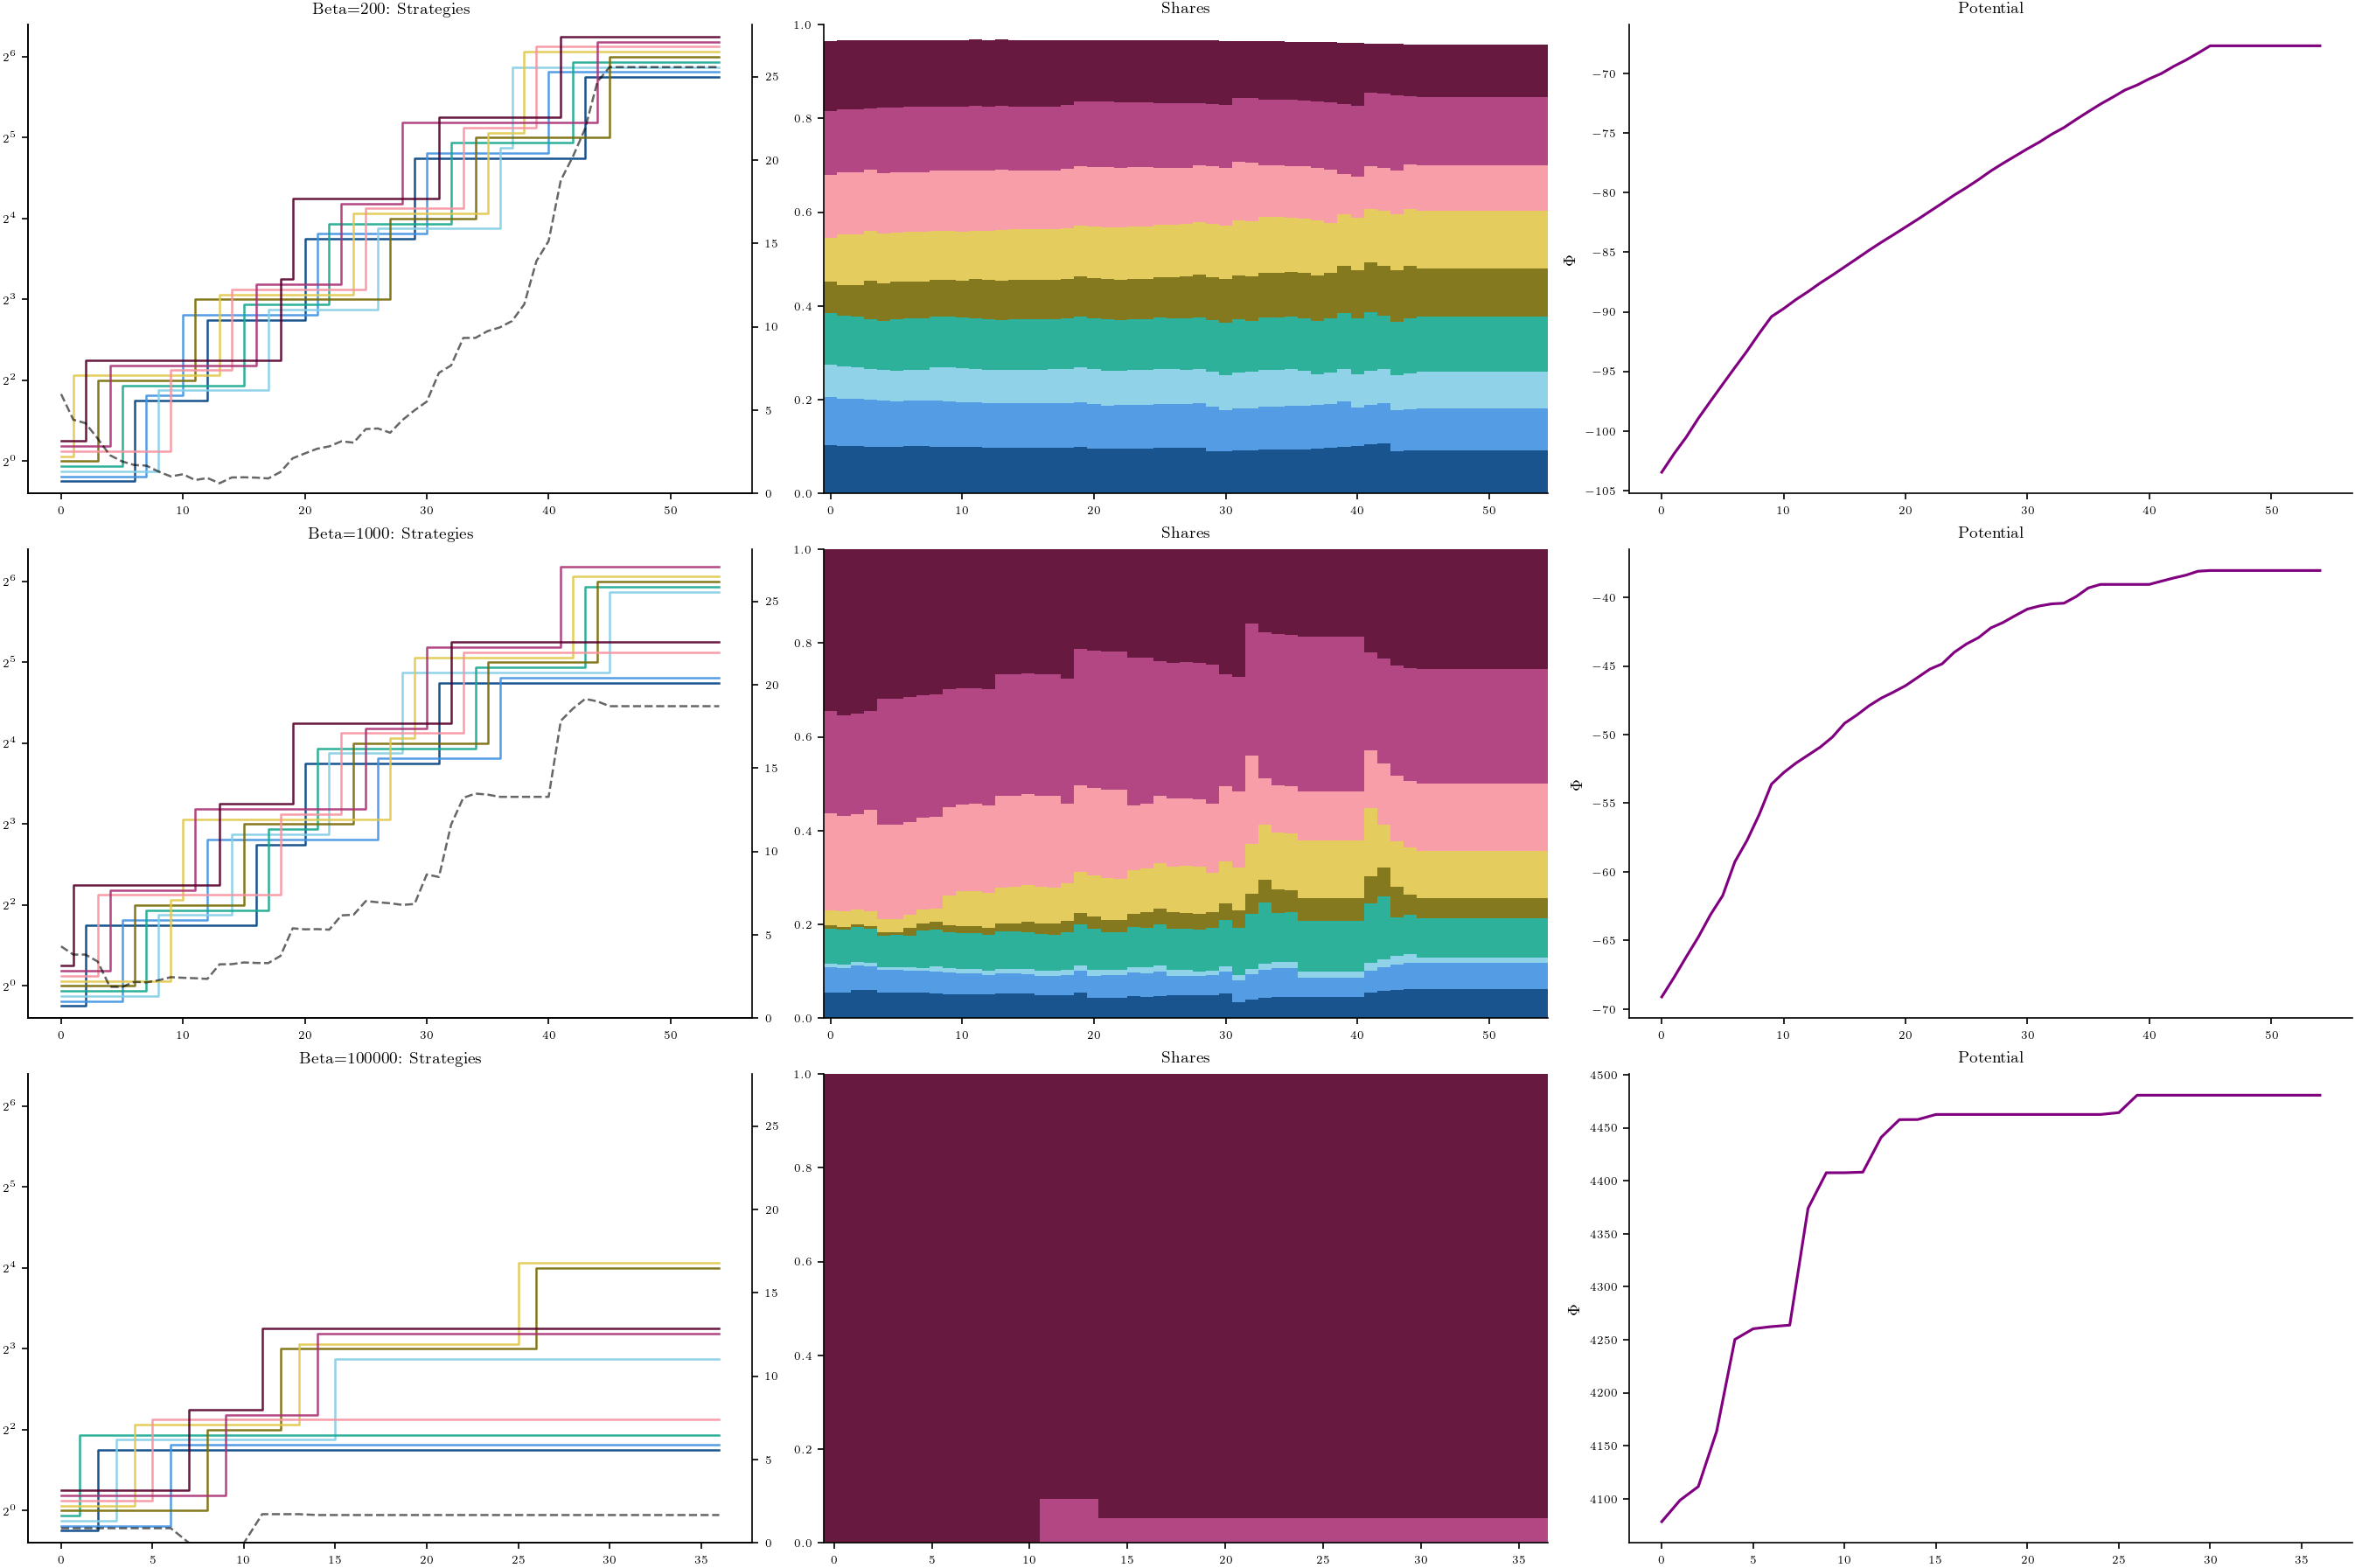

In [ ]:
ut.bet_pot_analysis(
    unreasoning_providers,
    thetas_unreasoning,
    betas_to_test,
    market_dynamics_unreasoning,
    base_filename=f"../figures/{BENCHMARK}/dynamics/unreasoning/{ttc_type}/convergence/",
    colors=model_color,
    reasoning=False,
)

ut.plot_market_shares(
    unreasoning_providers,
    betas_to_test,
    market_dynamics_unreasoning,
    base_filename=f"../figures/{BENCHMARK}/dynamics/unreasoning/{ttc_type}/convergence/",
    colors=model_color,
)

ut.plot_combined_dynamics(
    unreasoning_providers,
    thetas_unreasoning,
    betas_to_test,
    market_dynamics_unreasoning,
    base_filename=f"../figures/{BENCHMARK}/dynamics/unreasoning/{ttc_type}/convergence/",
    colors=model_color,
    reasoning=False,
)

100%|██████████| 5/5 [00:29<00:00,  5.82s/it]


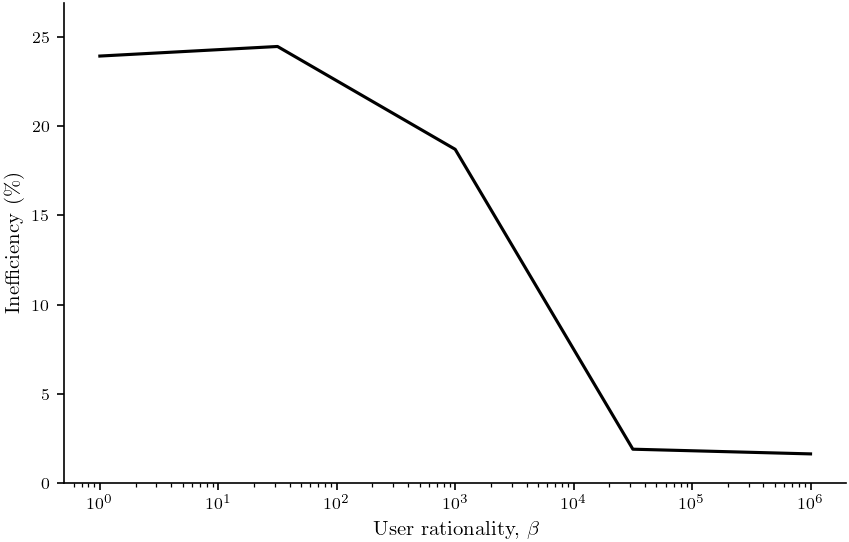

In [ ]:
final_poas, final_potentials = gm.sweep_beta_vs_poa(unreasoning_providers, config, np.logspace(0, 6, num=100))

ut.plot_beta_sweep(
    np.logspace(0, 6, num=100),
    final_poas,
    f"../figures/{BENCHMARK}/dynamics/unreasoning/{ttc_type}/convergence/",
)

## Reasoning models

In [ ]:
ttc_type = "relative_efforts"
reasoning_providers = gm.init_providers(reasoning_plot_data, ttc_type=ttc_type)
thetas_reasoning = np.array([1, 2, 3, 4, 5])

Initializing provider for reason-R1-D-Llama-8B...
Initializing provider for reason-R1-D-Qwen-1.5B...
Initializing provider for reason-R1-D-Qwen-7B...


### Value offered by providers vs compute level

Saved: ../figures/GSM8K/dynamics/reasoning/relative_efforts/values/v_curves.pdf


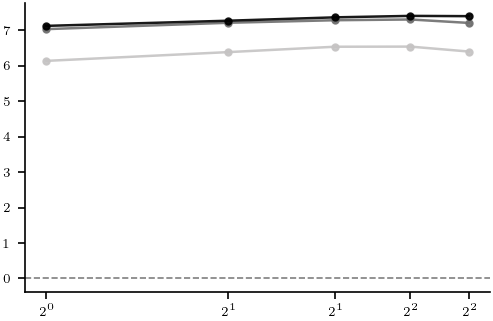

In [ ]:
Vs = gm.compute_V_curves(thetas_reasoning, reasoning_providers, config)

ut.plot_v_curves(
    Vs,
    thetas_reasoning,
    config,
    f"../figures/{BENCHMARK}/dynamics/reasoning/{ttc_type}/values/",
    colors=model_color,
)

### Analyze market dynamics

In [ ]:
betas_to_test = [200, 1000, 100000]
profit_margin = 0.25

market_dynamics_reasoning = gm.compute_market_dynamics(
    betas_to_test, profit_margin, reasoning_providers, config
)

100%|██████████| 3/3 [00:00<00:00, 368.61it/s]


In [ ]:
compare_market_to_auction(
    betas=betas_to_test,
    market_dynamics=market_dynamics_reasoning,
    value_curves=Vs,
    providers=reasoning_providers,
    base_config=config,
    profit_margin=profit_margin
)

BETA: 200
	Average Weighted Value: 0.00651
	Average Value: 0.00700
	Optimal SW: 0.00661, Equilibrium SW: 0.00654
	Average Weighted Price: 0.00016
	Average Price: 0.00017
	Average Weighted Utility: 0.00003
	Average Utility: 0.00003

BETA: 1000
	Average Weighted Value: 0.00716
	Average Value: 0.00700
	Optimal SW: 0.00724, Equilibrium SW: 0.00719
	Average Weighted Price: 0.00018
	Average Price: 0.00017
	Average Weighted Utility: 0.00004
	Average Utility: 0.00003

BETA: 100000
	Average Weighted Value: 0.00740
	Average Value: 0.00708
	Optimal SW: 0.00745, Equilibrium SW: 0.00745
	Average Weighted Price: 0.00023
	Average Price: 0.00015
	Average Weighted Utility: 0.00005
	Average Utility: 0.00003

AUCTION RESULTS
Winner: reason-R1-D-Qwen-7B (W=0.00745)
Runner-up: reason-R1-D-Qwen-1.5B (W=0.00733)

	Realized User Value: 0.00733
	Realized Price: 0.00030
	Realized Utility: 0.00012
	Total SW: 0.00745
-------------------------------------------------------------------------------------------------

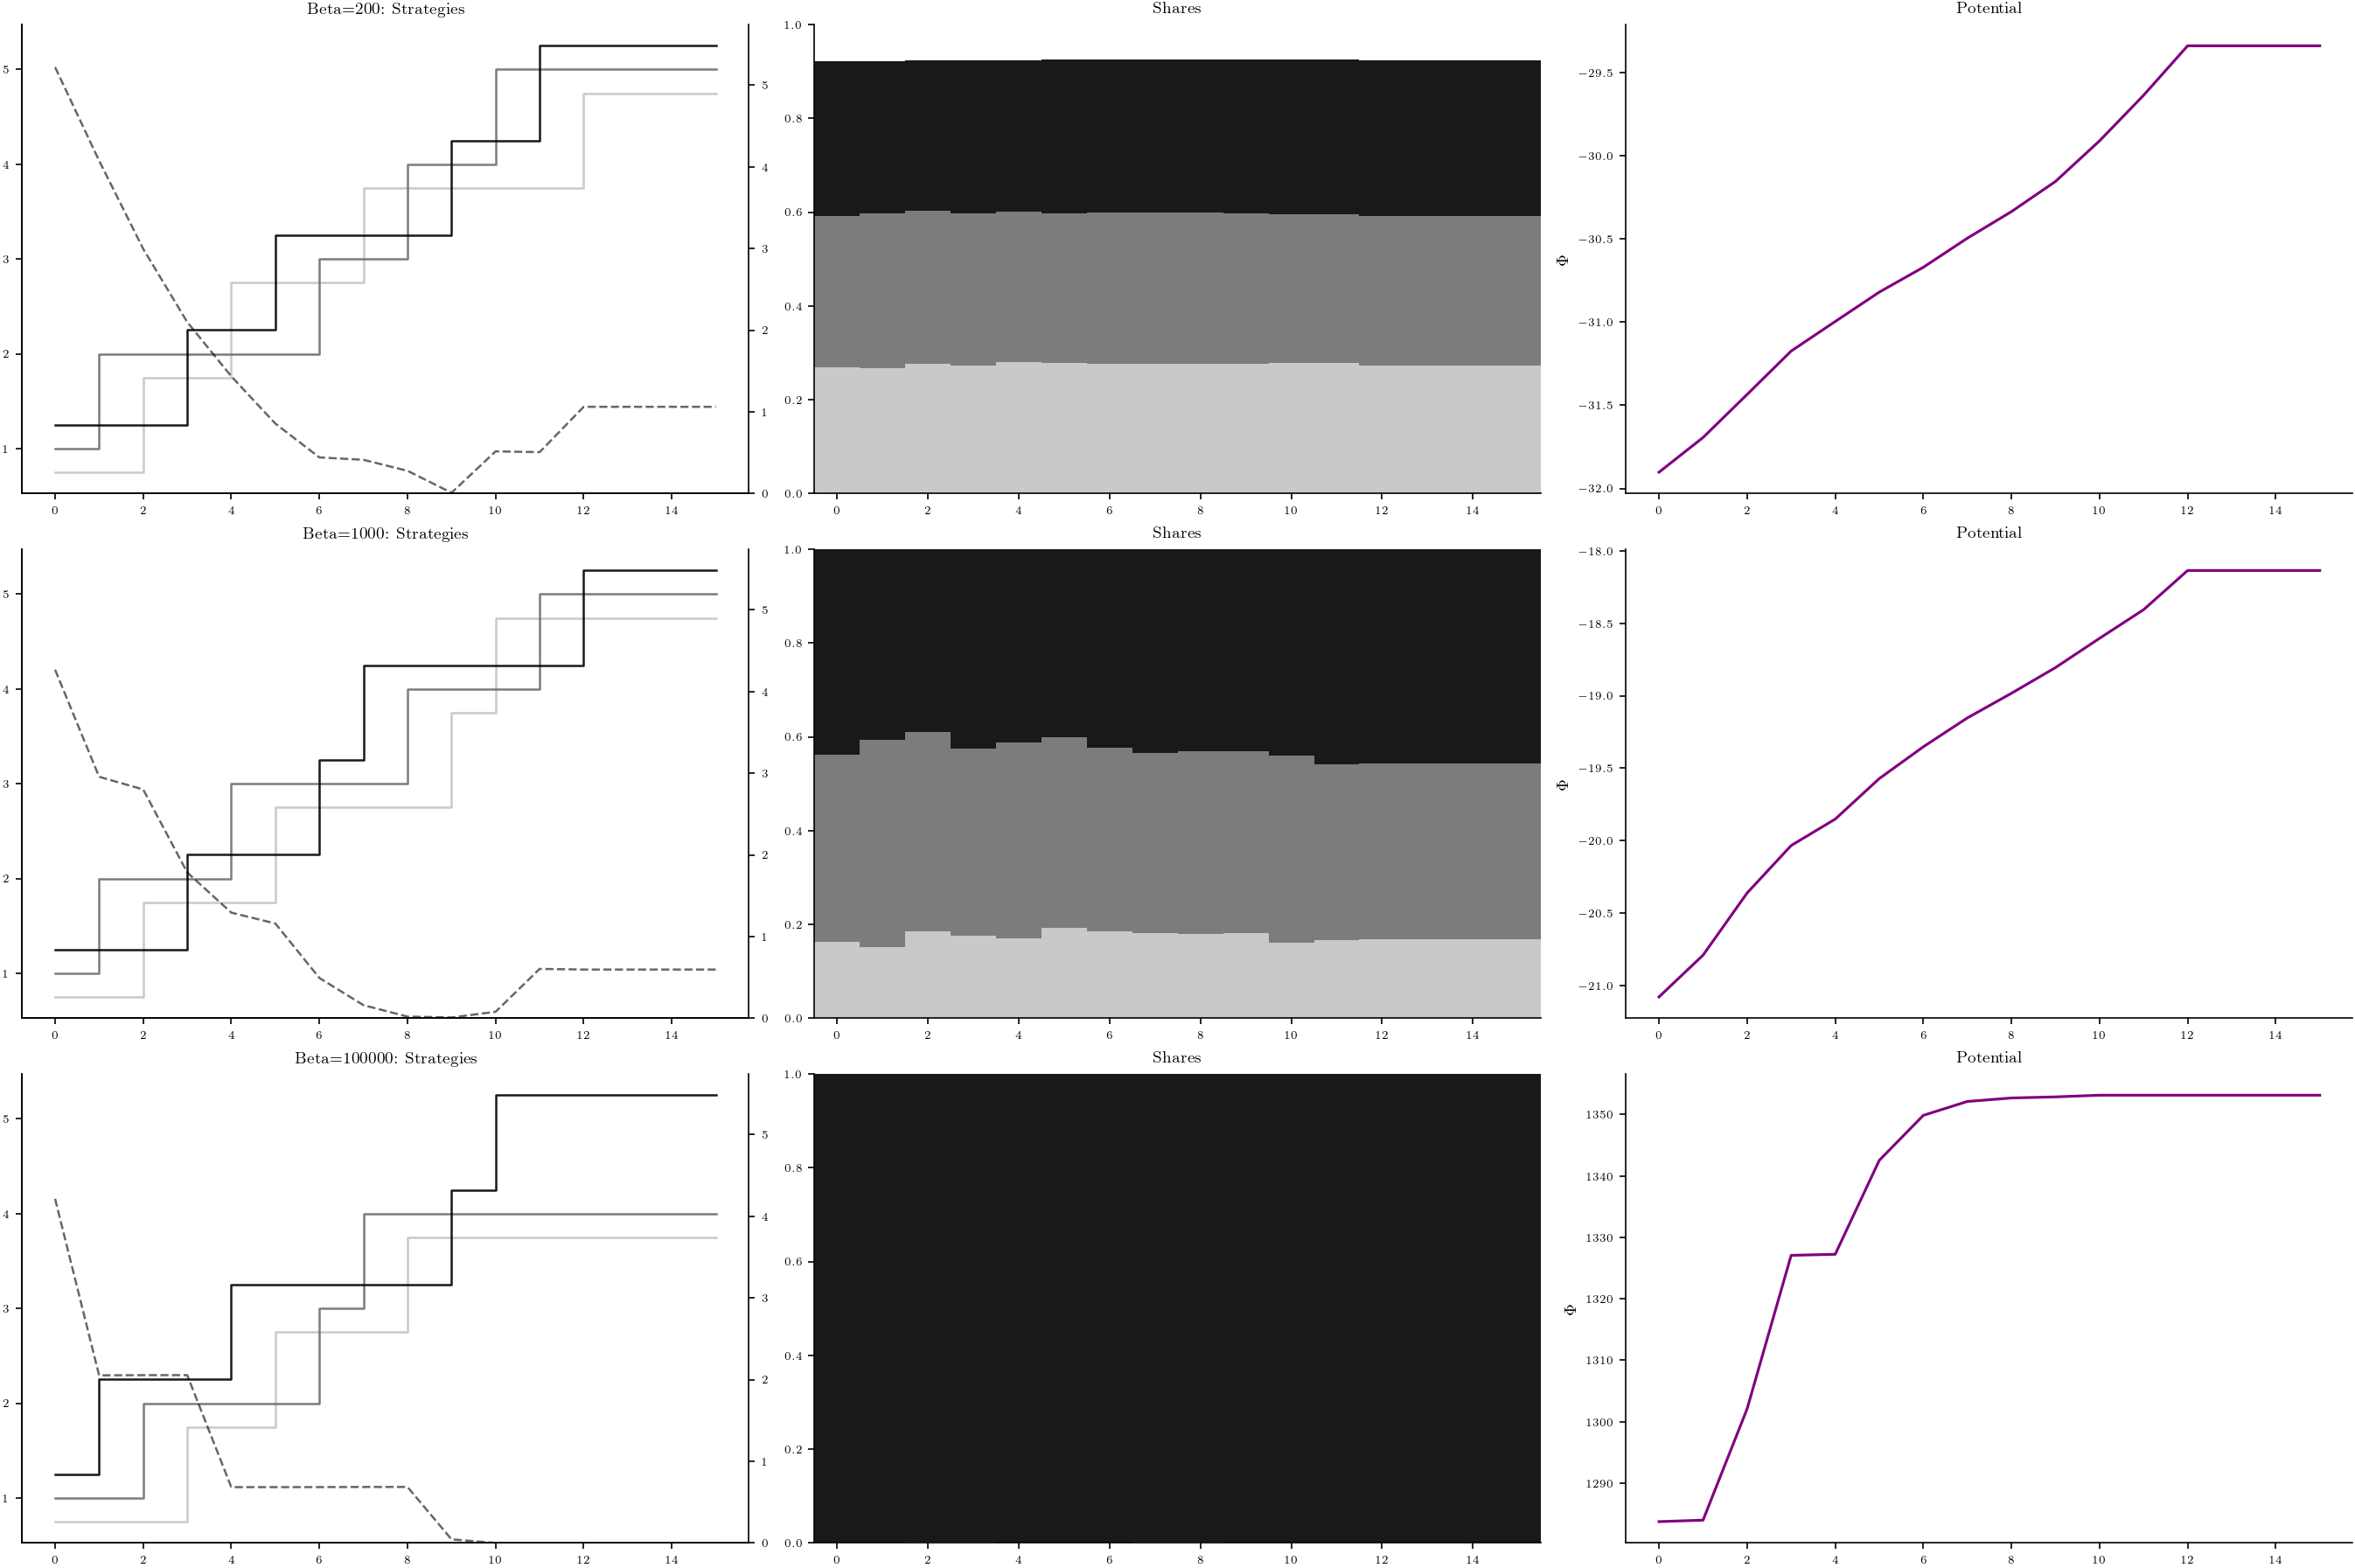

In [ ]:
ut.bet_pot_analysis(
    reasoning_providers,
    thetas_reasoning,
    betas_to_test,
    market_dynamics_reasoning,
    base_filename=f"../figures/{BENCHMARK}/dynamics/reasoning/{ttc_type}/convergence/",
    colors=model_color,
    reasoning=True,
)

ut.plot_market_shares(
    reasoning_providers,
    betas_to_test,
    market_dynamics_reasoning,
    base_filename=f"../figures/{BENCHMARK}/dynamics/reasoning/{ttc_type}/convergence/",
    colors=model_color,
)

ut.plot_combined_dynamics(
    reasoning_providers,
    thetas_reasoning,
    betas_to_test,
    market_dynamics_reasoning,
    base_filename=f"../figures/{BENCHMARK}/dynamics/reasoning/{ttc_type}/convergence/",
    colors=model_color,
    reasoning=True,
)

100%|██████████| 5/5 [00:00<00:00, 364.05it/s]


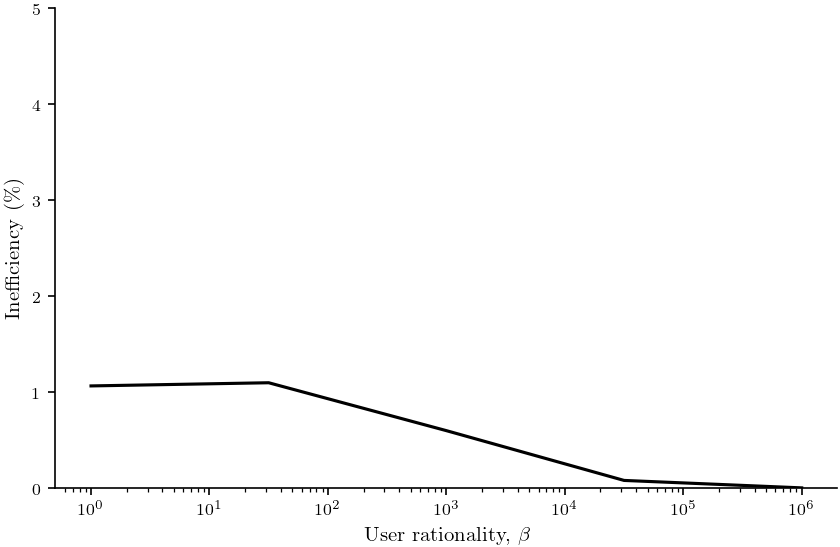

In [ ]:
final_poas, final_potentials = gm.sweep_beta_vs_poa(reasoning_providers, config, np.logspace(0, 6, num=100))

ut.plot_beta_sweep(
    np.logspace(0, 6, num=100),
    final_poas,
    f"../figures/{BENCHMARK}/dynamics/reasoning/{ttc_type}/convergence/",
)